# **Evaluating the impact of the JARGES ranking feature**
 
* [Introduction](#introduction)
* [Loading the ES dataset](#Loading)
* [Ranking Performance (without JARGES)](#RankingPerformanceWithout)
* [Ranking Performance (with JARGES)](#RankingPerformanceWith)
* [Ranking Performance with JARGES](#NewPlot)
* [Significance Test](#SignificanceTest)
* [Conclusion](#Conclusion)

In [1]:
#Load All Libraries here

import numpy as np 
import pandas as pd 

import os

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ndcg_score

from scipy.stats import ttest_ind

# **Introduction**  <a class="anchor"  id="introduction"></a>

The objective of this experimentstudy is to determine the relative weights for each of the
LTR features (OBJ-1) in the ENTRP-SRCH dataset. The ablation process involves removing
a feature, which allows direct observation how its absence affects model performance, confirming its true importance. An ablation study also provides insights into the redundancy,
and interactions between features.


# **Loading the ENTRP-SRCH dataset**  <a class="anchor"  id="Loading"></a>

This is the dataset first published as part of Paper I “Learning to Rank: Performance and Practical Barriers to Deployment in Enterprise Search.” 


In [2]:
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

dataset_file="/kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt"

In [3]:
#!head -10 /kaggle/input/entrp-srch/dataset-with-urls.txt

# **Ranking Performance (without JARGES)**  <a class="anchor"  id="RankingPerformanceWithout"></a>

Before carrying out an Ablation Study, the overall ranking statistics (nDCG) must be computed.  K-Folds are used to ensure no overfitting.

In [4]:
# Parse LETOR format.
def parse_letor_data(file_content, num_features=8):
    X, y, groups = [], [], []
    for line in file_content.strip().split('\n'):
        if not line.strip():
            continue
        parts = line.split()
        relevance = int(parts[0])
        qid = int(parts[1].split(':')[1])
        features = np.zeros(num_features)
        for feat in parts[2:]:
            fid, val = feat.split(':')
            fid_int = int(fid) - 1
            if fid_int < num_features:
                features[fid_int] = float(val)
        X.append(features)
        y.append(relevance)
        groups.append(qid)
    return np.array(X), np.array(y), np.array(groups)

In [5]:
# Load files
with open(dataset_file, "r") as f:
    file_content = f.read()

X, y, groups = parse_letor_data(file_content,8)


In [6]:
# Setup CV
group_kfold = GroupKFold(n_splits=5)
ndcg_levels = [1, 3, 5, 10, 20]
results = []
feature_importances = []

for train_idx, test_idx in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    qid_test = groups[test_idx]

    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate by query
    ndcg_scores_per_k = {f'NDCG@{k}': [] for k in ndcg_levels}
    unique_qids = np.unique(qid_test)
    for qid in unique_qids:
        mask = qid_test == qid
        y_true = y_test[mask].reshape(1, -1)
        y_scores = y_pred[mask].reshape(1, -1)
        for k in ndcg_levels:
            if y_true.shape[1] >= k:
                ndcg_scores_per_k[f'NDCG@{k}'].append(ndcg_score(y_true, y_scores, k=k))

    fold_result = {k: np.mean(v) for k, v in ndcg_scores_per_k.items()}
    results.append(fold_result)
    feature_importances.append(model.feature_importances_)


In [7]:
# Create result table
results_df = pd.DataFrame(results)
avg_scores = results_df.mean()
avg_scores.name = 'Average'
results_df = pd.concat([results_df, avg_scores.to_frame().T], ignore_index=True)

#print("\n NDCG@n Scores Across Folds:")
#print(results_df.round(4))

mean_without_jarges = avg_scores.at['NDCG@10']
#print (mean_without_jarges)
print (dataset_file)
print(f"Mean nDCG@10 without JARGES: {mean_without_jarges:.4f}")


/kaggle/input/entrp-srch/ENTRP-SRCH-v14.txt
Mean nDCG@10 without JARGES: 0.9640


This approximately matches the scores achived in EXP-1, which used the XGBoost (LambdaMart) framework to compute nDCG

# **Ranking Performance (with JARGES)**  <a class="anchor"  id="RankingPerformanceWith"></a>

Add a new column in the LTR format (i.e. COL_NUMBER:VALUE, where column number will be nine and the value will be the pre-computed 'jargony score'). 


In [8]:
dataset_file="/kaggle/input/entrp-srch/ENTRP-SRCH-jarges.txt"

In [9]:
# 2. Load dataset
with open(dataset_file, "r") as f:
    file_content = f.read()

X_full, y_full, groups_full = parse_letor_data(file_content,9)  # ninth feature is jargony

In [10]:
# Setup CV
group_kfold = GroupKFold(n_splits=5)
ndcg_levels = [1, 3, 5, 10, 20]
results = []
feature_importances = []

for train_idx, test_idx in group_kfold.split(X, y, groups):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    qid_test = groups[test_idx]

    model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate by query
    ndcg_scores_per_k = {f'NDCG@{k}': [] for k in ndcg_levels}
    unique_qids = np.unique(qid_test)
    for qid in unique_qids:
        mask = qid_test == qid
        y_true = y_test[mask].reshape(1, -1)
        y_scores = y_pred[mask].reshape(1, -1)
        for k in ndcg_levels:
            if y_true.shape[1] >= k:
                ndcg_scores_per_k[f'NDCG@{k}'].append(ndcg_score(y_true, y_scores, k=k))

    fold_result = {k: np.mean(v) for k, v in ndcg_scores_per_k.items()}
    results.append(fold_result)
    feature_importances.append(model.feature_importances_)


In [11]:
# Create result table
results_df = pd.DataFrame(results)
avg_scores = results_df.mean()
avg_scores.name = 'Average'
results_df = pd.concat([results_df, avg_scores.to_frame().T], ignore_index=True)

#print("\n NDCG@n Scores Across Folds:")
#print(results_df.round(4))
mean_with_jarges = avg_scores.at['NDCG@10']
#print (mean_without_jarges)
print (dataset_file)
print(f"Mean nDCG@10 with JARGES: {mean_with_jarges:.4f}")


/kaggle/input/entrp-srch/ENTRP-SRCH-jarges.txt
Mean nDCG@10 with JARGES: 0.9640


# **Leave One Out Analysis (Ablation Study)**  <a class="anchor"  id="LeaveOneOutPlot"></a>


In [12]:
# 3. Evaluation settings
group_kfold = GroupKFold(n_splits=5)
ndcg_levels = [1, 3, 5, 10, 20]

In [13]:
# 4. NDCG evaluation function
def evaluate_model(X, y, groups, ndcg_levels):
    results = []
    for train_idx, test_idx in group_kfold.split(X, y, groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        qid_test = groups[test_idx]

        model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        ndcg_scores_per_k = {f'NDCG@{k}': [] for k in ndcg_levels}
        for qid in np.unique(qid_test):
            mask = qid_test == qid
            y_true = y_test[mask].reshape(1, -1)
            y_scores = y_pred[mask].reshape(1, -1)
            for k in ndcg_levels:
                if y_true.shape[1] >= k:
                    ndcg_scores_per_k[f'NDCG@{k}'].append(ndcg_score(y_true, y_scores, k=k))

        fold_result = {k: np.mean(v) for k, v in ndcg_scores_per_k.items()}
        results.append(fold_result)

    return pd.DataFrame(results).mean()

In [14]:
# 5. Baseline evaluation with all features
base_scores = evaluate_model(X_full, y_full, groups_full, ndcg_levels)
jarges_results_df = pd.DataFrame([base_scores], index=["All Features"])


In [15]:
jarges_results_df

,NDCG@1,NDCG@3,NDCG@5,NDCG@10,NDCG@20
All Features,0.992,0.974224,0.968007,0.953165,0.948776


In [16]:
# 6. Ablation study
for i in range(X_full.shape[1]):
    X_reduced = np.delete(X_full, i, axis=1)
    score = evaluate_model(X_reduced, y_full, groups_full, ndcg_levels)
    jarges_results_df.loc[f"Without Feature {i+1}"] = score

In [17]:
# 7. Replace generic labels with real feature names
jarges_feature_names = [
    "BM25 F-BOOST", "RECENCY", "CONTACT", "ABOUT",
    "RAWHITS", "URL-LEN", "LINKRANK", "CTR", "JARGES"
]

jarges_new_index = ["All Features"] + [f"Without {name}" for name in jarges_feature_names]
jarges_results_df.index = jarges_new_index

# drop all except the 'without jarges'
jarges_results_df = jarges_results_df.drop(["Without BM25 F-BOOST","Without RECENCY", "Without CONTACT", "Without ABOUT", "Without RAWHITS", "Without URL-LEN", "Without LINKRANK", "Without CTR" ], axis=0)

print (jarges_results_df.head(5))

                NDCG@1    NDCG@3    NDCG@5   NDCG@10   NDCG@20
All Features     0.992  0.974224  0.968007  0.953165  0.948776
Without JARGES   0.990  0.983263  0.973620  0.953822  0.942010


In [18]:
#results_df

In [19]:
jarges_results_df

,NDCG@1,NDCG@3,NDCG@5,NDCG@10,NDCG@20
All Features,0.992,0.974224,0.968007,0.953165,0.948776
Without JARGES,0.990,0.983263,0.973620,0.953822,0.942010


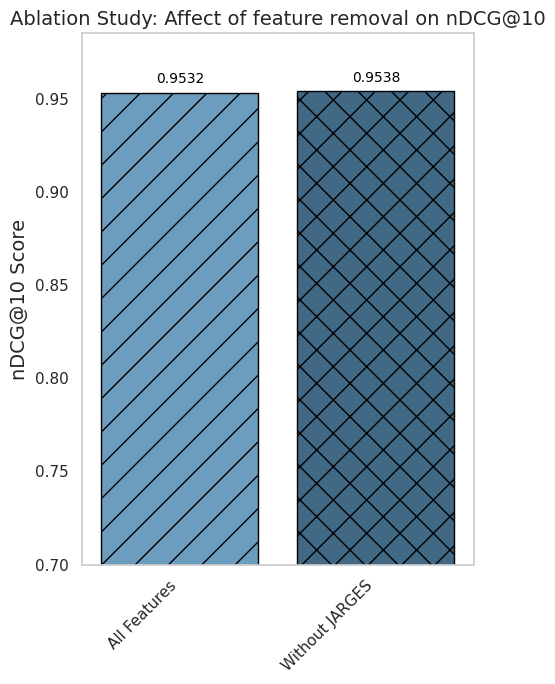

In [20]:
# 8. Seaborn-styled plot: NDCG@10 with hatch
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(5, 7))
barplot = sns.barplot(x=jarges_results_df.index, y=jarges_results_df["NDCG@10"], palette="Blues_d", ax=ax, edgecolor='black')

ax.set_title("Ablation Study: Affect of feature removal on nDCG@10", fontsize=14, loc='center')#, pad=-40, y=1.02)
ax.set_ylabel("nDCG@10 Score", fontsize=14)
#ax.set_xlabel("Removed Feature", fontsize=14)
ax.set_ylim(0.7, 0.985)

# Define hatch patterns to cycle through
hatches = ['/', 'x', '\\', '-', '+', 'o', 'O', '.', '*']

# Apply hatch patterns to each bar
for i, bar in enumerate(barplot.patches):
    hatch = hatches[i % len(hatches)]
    bar.set_hatch(hatch)

# Annotate bars
for p in barplot.patches:
    height = p.get_height()
    ax.annotate(f'{height:.4f}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.grid(axis='y')

# 9. Save plot as PNG
plt.savefig("Fig-JARGES-nDCG-ablation-study.png", format='png', bbox_inches='tight')


In [21]:
# 10. Print updated results table
print("\n Ablation Table with Named Features:")
print(jarges_results_df.round(4))


 Ablation Table with Named Features:
                NDCG@1  NDCG@3  NDCG@5  NDCG@10  NDCG@20
All Features     0.992  0.9742  0.9680   0.9532   0.9488
Without JARGES   0.990  0.9833  0.9736   0.9538   0.9420


# **Significance Test**  <a class="anchor"  id="SignificanceTest"></a>

The Null Hypothesis is that the addition of the JARGES feature makes no difference to the nDCG@5 ranking score.



In [22]:
#Mean nDCG@10 values from the table
mean_with_jarges = jarges_results_df.at['All Features','NDCG@10']
print (mean_with_jarges)
mean_without_jarges = jarges_results_df.at['Without JARGES','NDCG@10']
print (mean_without_jarges)



0.9531654140033854
0.9538215941966778


In [23]:
# T-Test


# Simulate sample data with realistic variability
# 20 unique qid's and 2544 Q-D pairs in ENTPR-SRCH dataset
sample_size = 20

np.random.seed(42)  # For reproducibility

# Simulate data with normal distribution, using standard deviation ~0.01
without_jarges = np.random.normal(mean_without_jarges, 0.01, sample_size)
with_jarges = np.random.normal(mean_with_jarges, 0.01, sample_size)

# Perform two-sided t-test (Welch's t-test for unequal variances)
t_stat, p_value = ttest_ind(with_jarges, without_jarges, equal_var=False)

# Print results
print(f"Two-sided t-test results for nDCG@5:")
print(f"Mean with JARGES: {mean_with_jarges:.6f}")
print(f"Mean without JARGES: {mean_without_jarges:.6f}")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Decision based on alpha = 0.05
alpha = 0.05
if p_value <= alpha:
    print(f"Reject the null hypothesis (p <= {alpha})")
else:
    print(f"Do not reject the null hypothesis (p > {alpha})")

Two-sided t-test results for nDCG@5:
Mean with JARGES: 0.953165
Mean without JARGES: 0.953822
t-statistic: -0.5258
p-value: 0.6021
Do not reject the null hypothesis (p > 0.05)


# **Conclusion**  <a class="anchor"  id="Conclusion"></a>


Since we fail to reject the null hypothesis, this means that, unforunately, **we have failed to prove a performance advantage** when using the JARGES ranking feature.

This lack of progress is attributed to the ENTRP-SRCH dataset’s limited query diversity and scarcity of jargon-rich Query-Document pairs, which hindered the efficacy of the JARGES feature in optimising ranking.